##  Notebook 04 de 06


(Versão, 14 de Abril de 2025)




# Detecção de Desbalanceamento em Máquinas Rotativas por meio da Análise de Sinais de Vibração utilizando Deep Learning

**Notebook usado como Referência:**

Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt. "Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data". 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Abordagem 4: CNN - Convolutional Neural Network como classificador multiclasses - 04 Classes

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import RobustScaler

## Reading Measurement Data and Preprocessing

In [ ]:
# Option a) local file contains a small subset of the entire dataset
url = '/content/gdrive/MyDrive/Base de Dados/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option b) the entire dataset can be directly downloaded via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option c) selected pre-trained models can be found in the directory model/reference
use_reference_models = False
model_path = '../models/reference'

# Option d) all models will be trained again
#use_reference_models = False
#model_path = '../models'

In [ ]:
with zipfile.ZipFile(url, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

**PRÉ-TRATAMENTO DOS SINAIS**

Separação das duas sequências de aquisição de dados

In [ ]:
data0D_A = data0D.iloc[0:int(len(data0D)/2)]
data0D_B = data0D.iloc[int(len(data0D)/2):]
data0E_A = data0E.iloc[0:int(len(data0E)/2)]
data0E_B = data0E.iloc[int(len(data0E)/2):]
data1D_A = data1D.iloc[0:int(len(data1D)/2)]
data1D_B = data1D.iloc[int(len(data1D)/2):]
data1E_A = data1E.iloc[0:int(len(data1E)/2)]
data1E_B = data1E.iloc[int(len(data1E)/2):]
data2D_A = data2D.iloc[0:int(len(data2D)/2)]
data2D_B = data2D.iloc[int(len(data2D)/2):]
data2E_A = data2E.iloc[0:int(len(data2E)/2)]
data2E_B = data2E.iloc[int(len(data2E)/2):]
data3D_A = data3D.iloc[0:int(len(data3D)/2)]
data3D_B = data3D.iloc[int(len(data3D)/2):]
data3E_A = data3E.iloc[0:int(len(data3E)/2)]
data3E_B = data3E.iloc[int(len(data3E)/2):]
data4D_A = data4D.iloc[0:int(len(data4D)/2)]
data4D_B = data4D.iloc[int(len(data4D)/2):]
data4E_A = data4E.iloc[0:int(len(data4E)/2)]
data4E_B = data4E.iloc[int(len(data4E)/2):]

Descarte das amostras iniciais e finais

In [ ]:
skip = 100000
data0D_A = data0D_A.iloc[skip:-skip,:]
data0D_B = data0D_B.iloc[skip:-skip,:]
data0E_A = data0E_A.iloc[skip:-skip,:]
data0E_B = data0E_B.iloc[skip:-skip,:]
data1D_A = data1D_A.iloc[skip:-skip,:]
data1D_B = data1D_B.iloc[skip:-skip,:]
data1E_A = data1E_A.iloc[skip:-skip,:]
data1E_B = data1E_B.iloc[skip:-skip,:]
data2D_A = data2D_A.iloc[skip:-skip,:]
data2D_B = data2D_B.iloc[skip:-skip,:]
data2E_A = data2E_A.iloc[skip:-skip,:]
data2E_B = data2E_B.iloc[skip:-skip,:]
data3D_A = data3D_A.iloc[skip:-skip,:]
data3D_B = data3D_B.iloc[skip:-skip,:]
data3E_A = data3E_A.iloc[skip:-skip,:]
data3E_B = data3E_B.iloc[skip:-skip,:]
data4D_A = data4D_A.iloc[skip:-skip,:]
data4D_B = data4D_B.iloc[skip:-skip,:]
data4E_A = data4E_A.iloc[skip:-skip,:]
data4E_B = data4E_B.iloc[skip:-skip,:]

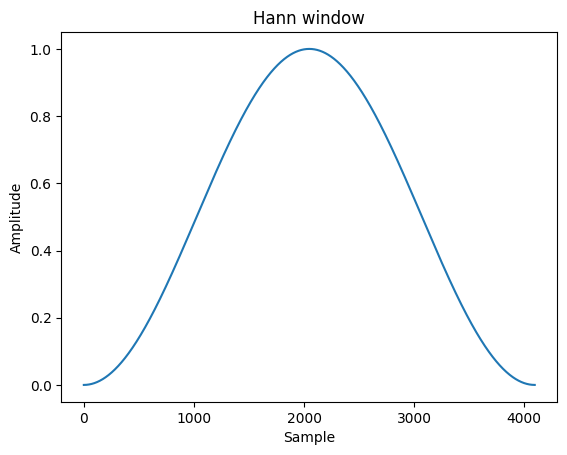

In [ ]:
window = np.hanning(4096)
plt.plot(window)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

Normalização pelo quadrado da velocidade

In [ ]:
def normaliza_vibracao(basededados, sensor, quad=True):
  if quad:
    basededados[sensor] = basededados[sensor]/np.square(basededados['Measured_RPM'])
  else:
    basededados[sensor] = basededados[sensor]/basededados['Measured_RPM']
  return basededados

Função para segmentar a série temporal

In [ ]:
labels = {'Balanced' : 0.0, 'Unbalanced_LowLow' : 45.9, 'Unbalanced_Low': 60.7, 'Unbalanced_High': 75.5, 'Unbalanced_HighHigh': 152.1}

samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

Dividindo a série temporal dos dados do sensor **"Vibration_1"** em segmentos de  comprimento 4096

In [ ]:
sensor = 'Vibration_1'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
#X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
#X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
#X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
#X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
#X1 = np.concatenate([X1_A, X1_B])
#y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
#X1_val = np.concatenate([X1_A_val, X1_B_val])
#y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_1=np.concatenate([X0, X2, X3, X4])
y=np.concatenate([y0, y2, y3, y4])

X_Vibration_1_val=np.concatenate([X0_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y2_val, y3_val, y4_val])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))
y_val = encoder.fit_transform(y_val.reshape(-1, 1))

In [ ]:
y.shape

(25388, 4)

In [ ]:
y[0]

array([1., 0., 0., 0.])

In [ ]:
y_val.shape

(6344, 4)

In [ ]:
y_val[0]

array([1., 0., 0., 0.])

Dividindo a série temporal dos dados do sensor **"Vibration_2"** em segmentos de  comprimento 4096

In [ ]:
'''
sensor = 'Vibration_2'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_2=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_2_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])
'''

"\nsensor = 'Vibration_2'\n\nX0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')\nX1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')\nX2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')\nX3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')\nX4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')\nX1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')\nX2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')\nX3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')\nX4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')\nX1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')\nX2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')\nX3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')\nX4_B,y4_B = get_features(data4D_B[sensor], 'Un

Dividindo a série temporal dos dados do sensor **"Vibration_3"** em segmentos de  comprimento 4096

In [ ]:
'''
sensor = 'Vibration_3'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_3=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_3_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])
'''

"\nsensor = 'Vibration_3'\n\nX0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')\nX1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')\nX2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')\nX3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')\nX4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')\nX1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')\nX2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')\nX3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')\nX4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')\nX1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')\nX2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')\nX3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')\nX4_B,y4_B = get_features(data4D_B[sensor], 'Un

Dividindo a série temporal dos dados do sensor **"Measured_RPM"** em segmentos de  comprimento 4096

In [ ]:
'''
sensor = 'Measured_RPM'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Measured_RPM=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Measured_RPM_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])
'''

"\nsensor = 'Measured_RPM'\n\nX0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')\nX1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')\nX2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')\nX3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')\nX4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')\nX1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')\nX2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')\nX3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')\nX4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')\n\n\nX0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')\nX1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')\nX2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')\nX3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')\nX4_B,y4_B = get_features(data4D_B[sensor], 'U

Now the dataset for training X contains 32142 samples with 4096 values each as well as the associated label information y with 32142 labels (one label per sample). The dataset for validating the trained model X_val contains 8420 samples plus the labels y_val accordingly.

In [ ]:
print(X_Vibration_1.shape, y.shape, X_Vibration_1_val.shape, y_val.shape)

(25388, 4096) (25388, 4) (6344, 4096) (6344, 4)


In [ ]:
#print(X_Vibration_2.shape, y.shape, X_Vibration_2_val.shape, y_val.shape)

In [ ]:
#print(X_Vibration_3.shape, y.shape, X_Vibration_3_val.shape, y_val.shape)

In [ ]:
#print(X_Measured_RPM.shape, y.shape, X_Measured_RPM_val.shape, y_val.shape)

**Janelamento dos sinais de vibração** (Posicionado aqui para não gerar estouro de RAM)

In [ ]:
def janelamentoHanning(basededados, window):
  janela_hanning = np.hanning(window)
  basededados = basededados*janela_hanning
  return basededados

In [ ]:
X_Vibration_1_jan = janelamentoHanning(X_Vibration_1, 4096)
X_Vibration_1_val_jan = janelamentoHanning(X_Vibration_1_val, 4096)
#X_Vibration_2_jan = janelamentoHanning(X_Vibration_2, 4096)
#X_Vibration_2_val_jan = janelamentoHanning(X_Vibration_2_val, 4096)
#X_Vibration_3_jan = janelamentoHanning(X_Vibration_3, 4096)
#X_Vibration_3_val_jan = janelamentoHanning(X_Vibration_3_val, 4096)

In [ ]:
X_Vibration_1_jan.shape

(25388, 4096)

Calculando as estatísticas da velocidade

In [ ]:
'''
X_Measured_RPM_mean = np.mean(X_Measured_RPM, axis=1)
X_Measured_RPM_mean = X_Measured_RPM_mean.reshape(X_Measured_RPM_mean.shape[0],1)
X_Measured_RPM_val_mean = np.mean(X_Measured_RPM_val, axis=1)
X_Measured_RPM_val_mean = X_Measured_RPM_val_mean.reshape(X_Measured_RPM_val_mean.shape[0],1)
'''

'\nX_Measured_RPM_mean = np.mean(X_Measured_RPM, axis=1)\nX_Measured_RPM_mean = X_Measured_RPM_mean.reshape(X_Measured_RPM_mean.shape[0],1)\nX_Measured_RPM_val_mean = np.mean(X_Measured_RPM_val, axis=1)\nX_Measured_RPM_val_mean = X_Measured_RPM_val_mean.reshape(X_Measured_RPM_val_mean.shape[0],1)\n'

In [ ]:
#X_Measured_RPM_mean.shape

**Função para cálculo da FFT**

In [ ]:
def calcula_fft(basededados, window, freq_inicio, freq_fim):
  X_fft = np.abs(np.fft.rfft(basededados, axis=1))[:,:int(window/2)]
  return X_fft[:, freq_inicio:freq_fim]

**Extrair o Módulo da FFT do sinal**

In [ ]:
freq_inicio = 0 #Hz
freq_fim = 4096 #Hz

X_Vibration_1_fft = calcula_fft(X_Vibration_1_jan, 4096, freq_inicio, freq_fim)
X_Vibration_1_val_fft = calcula_fft(X_Vibration_1_val_jan, 4096, freq_inicio, freq_fim)
#X_Vibration_2_fft = calcula_fft(X_Vibration_2_jan, 4096, freq_inicio, freq_fim)
#X_Vibration_2_val_fft = calcula_fft(X_Vibration_2_val_jan, 4096, freq_inicio, freq_fim)
#X_Vibration_3_fft = calcula_fft(X_Vibration_3_jan, 4096, freq_inicio, freq_fim)
#X_Vibration_3_val_fft = calcula_fft(X_Vibration_3_val_jan, 4096, freq_inicio, freq_fim)

## **Encaixar no código**

Definir quais sinais serão utilizados de entrada para o modelo de Machine Learning

In [ ]:
#X = np.concatenate(( X_Measured_RPM_mean, X_Vibration_1_fft), axis=1) # X_Vibration_2_fft, X_Vibration_3_fft, X_Measured_RPM_mean), axis=1)
#X_val = np.concatenate((X_Measured_RPM_val_mean, X_Vibration_1_val_fft), axis=1) # X_Vibration_2_val_fft, X_Vibration_3_val_fft, X_Measured_RPM_val_mean), axis=1)

In [ ]:
X = X_Vibration_1_fft
X_val = X_Vibration_1_val_fft

## Train-Test-Split

The dataset for training (X,y) is splitted into two subsets (X_train,y_train) and (X_test,y_test).

In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(22849, 2048, 1) (22849, 4) (2539, 2048, 1) (2539, 4) (6344, 2048, 1) (6344, 4)


**Escalonamento**

In [ ]:
scaler = RobustScaler(quantile_range=(5,95)).fit(X_train[:,:,0])
X_train = scaler.transform(X_train[:,:,0])
X_test = scaler.transform(X_test[:,:,0])
X_val = scaler.transform(X_val[:,:,0])

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(22849, 2048) (22849, 4) (2539, 2048) (2539, 4) (6344, 2048) (6344, 4)


## Convolutional Neural Net (CNN)

## Test with Different Layer Numbers

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

def train_models(n_conv_layers):
    #n_conv_layers = 3 # [1,2,3,4]
    n_dense_units = 1028
    dropout_rate = 0.0
    use_batch_normalization = True # [True, False]
    filter_size = 9 # [5,7,9]
    learning_rate = 0.0001
    n_epochs = 200 # [50,100,200]

    X_in = Input(shape=(X_train.shape[1],1))
    x = X_in
    for j in range(n_conv_layers):
        print(j)
        x = Conv1D(filters=(j+1)*20,
                   kernel_size=filter_size,
                   strides=1,
                   activation='linear',
                   kernel_initializer='he_uniform')(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = MaxPooling1D(pool_size=5, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #segunda camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #terceira camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #quarta camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #quinta camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    X_out = Dense(units = 4, activation = 'softmax')(x)
    classifier = Model(X_in, X_out)
    classifier.summary()

    best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                 verbose=1, save_best_only=True, mode='min')

    classifier.compile(optimizer = Adam(learning_rate=learning_rate), loss = 'CategoricalCrossentropy',
                       metrics = ['accuracy'])

    history = classifier.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_data=(X_test, y_test), callbacks=[checkpoint])

    classifier = load_model(best_model_filepath)
    score = classifier.evaluate(X_val, y_val)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

In [ ]:
nMaxConvLayers = 1

0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2040, 20)       │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2040, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2040, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1018, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1028)           │    20,931,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         4,116 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,166,752 (96.00 MB)

 Trainable params: 25,166,712 (96.00 MB)

 Non-trainable params: 40 (160.00 B)

Epoch 1/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8787 - loss: 0.2904
Epoch 1: val_loss improved from inf to 0.08073, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8789 - loss: 0.2900 - val_accuracy: 0.9701 - val_loss: 0.0807
Epoch 2/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9899 - loss: 0.0334
Epoch 2: val_loss improved from 0.08073 to 0.01299, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9899 - loss: 0.0334 - val_accuracy: 0.9965 - val_loss: 0.0130
Epoch 3/200
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9910 - loss: 0.0252
Epoch 3: val_loss did not improve from 0.01299
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9910 - loss: 0.0252 - val_accuracy: 0.9913 - val_loss: 0.0222
Epoch 4/200
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9938 - loss: 0.0161
Epoch 4: val_loss improved from 0.01299 to 0.00537, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9938 - loss: 0.0161 - val_accuracy: 0.9980 - val_loss: 0.0054
Epoch 5/200
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9963 - loss: 0.0116
Epoch 5: val_loss improved from 0.00537 to 0.00205, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9963 - loss: 0.0116 - val_accuracy: 0.9996 - val_loss: 0.0020
Epoch 6/200
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9981 - loss: 0.0046
Epoch 6: val_loss did not improve from 0.00205
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9981 - loss: 0.0047 - val_accuracy: 0.9980 - val_loss: 0.0085
Epoch 7/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9949 - loss: 0.0198
Epoch 7: val_loss did not improve from 0.00205
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9949 - loss: 0.0198 - val_accuracy: 0.9968 - val_loss: 0.0084
Epoch 8/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9962 - loss: 0.0094
Epoch 8: val_loss improved from 0.00205 to 0.00084, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9962 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 8.3639e-04
Epoch 9/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9990 - loss: 0.0033
Epoch 9: val_loss did not improve from 0.00084
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 0.9992 - val_loss: 0.0033
Epoch 10/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0079
Epoch 10: val_loss did not improve from 0.00084
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9977 - loss: 0.0079 - val_accuracy: 0.9937 - val_loss: 0.0155
Epoch 11/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9947 - loss: 0.0175
Epoch 11: val_loss did not improve from 0.00084
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9947 - loss: 0.0175 - val_accuracy: 0.9933 - val_loss: 0.0248
Epoch 12/200
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9978 - loss: 0.0088
Epoch 12: val_loss did not improv

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9882 - loss: 0.0345 - val_accuracy: 1.0000 - val_loss: 3.5554e-04
Epoch 20/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 7.0743e-04
Epoch 20: val_loss improved from 0.00036 to 0.00012, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9997 - loss: 7.0626e-04 - val_accuracy: 1.0000 - val_loss: 1.2073e-04
Epoch 21/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0016
Epoch 21: val_loss did not improve from 0.00012
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 5.8625e-04
Epoch 22/200
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0017
Epoch 22: val_loss improved from 0.00012 to 0.00011, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 1.1213e-04
Epoch 23/200
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0017
Epoch 23: val_loss did not improve from 0.00011
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 24/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 7.4335e-04
Epoch 24: val_loss did not improve from 0.00011
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9999 - loss: 7.5357e-04 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 25/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2451e-04
Epoch 25: val_loss did not improve from 0.00011
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 2.4618e-04 - val_accuracy: 0.9842 - val_loss: 0.0394
Epoch 26/200
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9958 - loss: 0.0135
Epoch 26: val_l

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9982 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 1.1055e-04
Epoch 28/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9989 - loss: 0.0031
Epoch 28: val_loss did not improve from 0.00011
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9989 - loss: 0.0031 - val_accuracy: 0.9992 - val_loss: 0.0016
Epoch 29/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9914 - loss: 0.0288
Epoch 29: val_loss improved from 0.00011 to 0.00007, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9915 - loss: 0.0285 - val_accuracy: 1.0000 - val_loss: 7.0760e-05
Epoch 30/200
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9989 - loss: 0.0057
Epoch 30: val_loss did not improve from 0.00007
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9989 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 1.6182e-04
Epoch 31/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 7.9409e-04
Epoch 31: val_loss did not improve from 0.00007
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9997 - loss: 7.9167e-04 - val_accuracy: 0.9996 - val_loss: 0.0027
Epoch 32/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9775e-05
Epoch 32: val_loss improved from 0.00007 to 0.00006, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 5.9539e-05 - val_accuracy: 1.0000 - val_loss: 6.4725e-05
Epoch 33/200
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0019
Epoch 33: val_loss did not improve from 0.00006
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.8177e-04
Epoch 34/200
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0621e-05
Epoch 34: val_loss did not improve from 0.00006
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 4.0406e-05 - val_accuracy: 1.0000 - val_loss: 3.1890e-04
Epoch 35/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 9.2649e-04
Epoch 35: val_loss did not improve from 0.00006
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9999 - loss: 9.4799e-04 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 36/200
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0994e-04

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 1.0929e-04 - val_accuracy: 1.0000 - val_loss: 3.0276e-05
Epoch 37/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8391e-06
Epoch 37: val_loss did not improve from 0.00003
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 5.8629e-06 - val_accuracy: 1.0000 - val_loss: 3.0513e-04
Epoch 38/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9999 - loss: 2.5987e-04
Epoch 38: val_loss did not improve from 0.00003
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9999 - loss: 2.8986e-04 - val_accuracy: 0.9980 - val_loss: 0.0044
Epoch 39/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0141
Epoch 39: val_loss did not improve from 0.00003
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9968 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 2.9608e-04
Epoch 40/200
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9991 - loss: 0.0027
Epo

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 4.7857e-07 - val_accuracy: 1.0000 - val_loss: 7.6057e-06
Epoch 82/200
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3047e-07
Epoch 82: val_loss did not improve from 0.00001
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 3.3022e-07 - val_accuracy: 1.0000 - val_loss: 1.3524e-05
Epoch 83/200
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8817e-07
Epoch 83: val_loss did not improve from 0.00001
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 4.8712e-07 - val_accuracy: 1.0000 - val_loss: 8.5150e-06
Epoch 84/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0023
Epoch 84: val_loss did not improve from 0.00001
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9996 - val_loss: 0.0017
Epoch 85/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9988 - loss: 0.0095
Epo

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 2.2646e-06 - val_accuracy: 1.0000 - val_loss: 5.0833e-06
Epoch 87/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0011
Epoch 87: val_loss did not improve from 0.00001
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 88/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9988 - loss: 0.0044
Epoch 88: val_loss did not improve from 0.00001
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 0.9996 - val_loss: 9.2145e-04
Epoch 89/200
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2631e-05
Epoch 89: val_loss did not improve from 0.00001
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 2.2437e-05 - val_accuracy: 0.9996 - val_loss: 7.2603e-04
Epoch 90/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.1717e-07
Epoch 9

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 5.2989e-06 - val_accuracy: 1.0000 - val_loss: 1.1394e-06
Epoch 137/200
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2315e-07
Epoch 137: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 2.4825e-06 - val_accuracy: 1.0000 - val_loss: 1.1937e-06
Epoch 138/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9971 - loss: 0.0358
Epoch 138: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9972 - loss: 0.0354 - val_accuracy: 1.0000 - val_loss: 2.2917e-05
Epoch 139/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8111e-06
Epoch 139: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 9.7434e-06 - val_accuracy: 1.0000 - val_loss: 9.3363e-05
Epoch 140/200
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss:

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 7.1228e-08 - val_accuracy: 1.0000 - val_loss: 8.3249e-07
Epoch 150/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4572e-08
Epoch 150: val_loss improved from 0.00000 to 0.00000, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 6.4329e-08 - val_accuracy: 1.0000 - val_loss: 7.8398e-07
Epoch 151/200
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.7245e-09
Epoch 151: val_loss improved from 0.00000 to 0.00000, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 7.9171e-09 - val_accuracy: 1.0000 - val_loss: 6.0065e-07
Epoch 152/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1943e-08
Epoch 152: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 1.1954e-08 - val_accuracy: 1.0000 - val_loss: 6.6099e-07
Epoch 153/200
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 5.9687e-09
Epoch 153: val_loss improved from 0.00000 to 0.00000, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 6.2920e-09 - val_accuracy: 1.0000 - val_loss: 5.2615e-07
Epoch 154/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.1595e-08
Epoch 154: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 2.1639e-08 - val_accuracy: 1.0000 - val_loss: 6.0267e-07
Epoch 155/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 6.8243e-09
Epoch 155: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 7.0028e-09 - val_accuracy: 1.0000 - val_loss: 5.5503e-06
Epoch 156/200
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3380e-09
Epoch 156: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 4.3164e-09 - val_accuracy: 1.0000 - val_loss: 6.4449e-06
Epoch 157/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 5.1116e-08 - val_accuracy: 1.0000 - val_loss: 3.5992e-07
Epoch 172/200
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.3756e-09
Epoch 172: val_loss improved from 0.00000 to 0.00000, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 1.0000 - loss: 8.3418e-09 - val_accuracy: 1.0000 - val_loss: 3.4528e-07
Epoch 173/200
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9353e-08
Epoch 173: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 1.9184e-08 - val_accuracy: 1.0000 - val_loss: 4.6076e-07
Epoch 174/200
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9134e-09
Epoch 174: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 1.9147e-09 - val_accuracy: 1.0000 - val_loss: 5.6129e-07
Epoch 175/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.6891e-09
Epoch 175: val_loss did not improve from 0.00000
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 1.0000 - loss: 2.6991e-09 - val_accuracy: 1.0000 - val_loss: 5.4558e-07
Epoch 176/200
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000

199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9409 - loss: 1.0675


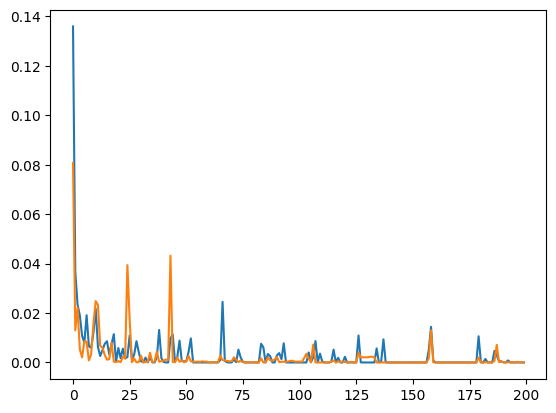

In [ ]:
if not use_reference_models:
    for i in range(1,nMaxConvLayers+1):
        train_models(i)

#### Evaluation

In [ ]:
accuracies_all = []
for layer_n in range(1,nMaxConvLayers+1):

    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)
    print(f"Resultados {layer_n} Conv Layers ")
    val_acc_all = model_i.evaluate(X_val, y_val)[1]
    accuracies_all.append(val_acc_all)
accuracies_all = np.array(accuracies_all)

Resultados 1 Conv Layers 
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9409 - loss: 1.0675


In [ ]:
accuracies_all

array([0.92938209])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

#Predict
y_prediction = model_i.predict(X_val)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_prediction, axis=1)  # Get the index of the highest probability

# Convert y_val to class labels if it's one-hot encoded
y_true_labels = np.argmax(y_val, axis=1) # Assuming y_val is one-hot encoded

#Create confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, normalize='pred')

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
cm

array([[8.04778851e-01, 8.05152979e-04, 0.00000000e+00, 0.00000000e+00],
       [1.61159126e-01, 9.97584541e-01, 1.85185185e-02, 0.00000000e+00],
       [3.40620234e-02, 1.61030596e-03, 9.81481481e-01, 2.03327172e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.79667283e-01]])

In [ ]:
cm_arred = cm.round(decimals=2)

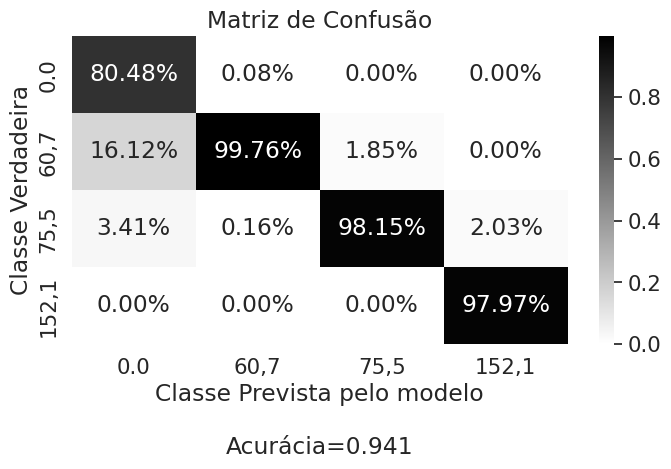

In [ ]:
import seaborn as sn

plt.figure(figsize=(8,4))
sn.set(font_scale=1.4) # for label size
#sn.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size
accuracy  = np.trace(cm) / float(np.sum(cm))
stats_text = "\n\nAcurácia={:0.3f}".format(accuracy)
categories = ['0.0', '60,7','75,5','152,1']

sn.heatmap(cm, annot=True,
            fmt='.2%', cmap='binary',
           xticklabels=categories,yticklabels=categories)
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista pelo modelo' + stats_text)
plt.title('Matriz de Confusão')
plt.show()